Finding hidden behavioral patterns and data linkage in personal data from Samsung Health app

by Sergey Amarin

I am a fan of Samsung products, especially mobile phones and accessories. So, for almost 2 years I’m wearing smartwatches from Samsung, which tracks a lot of data: counts steps and heartrate, shows active time and burned calories, sleep time and quality, weight, water and coffee intake, stress level and etc. Some data collects automatically, the others you need to input manually.  
Some time ago I got a notification from Samusug Health app with an interesting information: it mentioned that last week I had more sleep time and was more active. The app recommended me to sleep more. 

But is there really any linkage between this 2 parameters? 
I want to figure it out and will try to find some others patterns and correlations as well. Thankfully, Samsung Health app allows to download all user’s personal data with a single click. I will use my own data as well as some data prom my friends.

In [276]:
import sqlite3
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
from scipy.stats import spearmanr
import missingno as mno
from sklearn import linear_model
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import BayesianRidge

## Databse from SamsungHealth variables

In [277]:
#Importing database schema

from IPython.display import Image
img = 'Amarin_model.png'
Image(url=img)

## Creating pandas demo-data frame with database

With this data we want to find out if sleep time affects activity_time. sleep_time is stored in hours, activity time - in minutes

In [278]:
con = sqlite3.connect('Amarin_db4.db')
sleep_act = pd.read_sql_query("SELECT sleep.sleep_time, body_metrics.activity_time from sleep LEFT JOIN body_metrics ON body_metrics.key=sleep.key", con)
con.close()

# Verify that result of SQL query is stored in the dataframe
sleep_act

,sleep_time,activity_time
0,8.2,59.15
1,6.7,54.52
2,6.4,65.15
3,11.3,74.03
4,7.5,78.08
...,...,...
715,7.8,3.35
716,7.7,60.86
717,6.9,83.86
718,9.3,43.30


In [279]:
#Calculating short statistits
sleep_act.describe()

,sleep_time,activity_time
count,720.000000,667.000000
mean,8.115556,68.322174
std,3.112165,47.987648
min,0.600000,0.000000
25%,6.800000,39.505000
50%,7.900000,59.860000
75%,9.200000,85.780000
max,24.800000,552.570000


We can see that maximum sleep_time values seems to be too large and their amount is small (75% is 9.2 hours), so to avoid the distortion of results, we will filter the data with SQL query. 

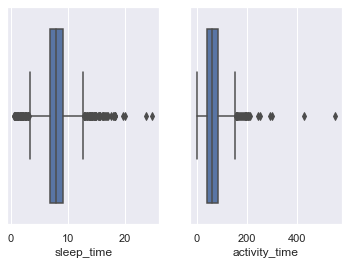

In [280]:
#outlier detection

fig, ax =plt.subplots(1,2)
sns.boxplot(sleep_act.sleep_time, ax=ax[0])
sns.boxplot(sleep_act.activity_time, ax = ax[1])

In [281]:
print('Upper border for sleep time = ' + str(sleep_act.sleep_time.mean() + sleep_act.sleep_time.std()*1.5))
print('Lower border for sleep time = ' + str(sleep_act.sleep_time.mean() - sleep_act.sleep_time.std()*1.5))
print('Upper border for activity time = ' + str(sleep_act.activity_time.mean()+sleep_act.activity_time.std()*1.5))
print('Lower border for activity time = ' + str(sleep_act.activity_time.mean()-sleep_act.activity_time.std()*1.5))

Upper border for sleep time = 12.78380313531446
Lower border for sleep time = 3.4473079757966474
Upper border for activity time = 140.30364582872505
Lower border for activity time = -3.6592980026381525


Boxplot shows that all sleep_time values higher than approximately value 13 and lower than approximately 4 hours - are oulliers 

In [282]:
#Cutting outliers

con = sqlite3.connect('Amarin_db4.db')
sleep_act_cut = pd.read_sql_query("SELECT sleep.sleep_time, body_metrics.activity_time from sleep LEFT JOIN body_metrics ON body_metrics.key=sleep.key WHERE sleep.sleep_time BETWEEN 4 and 13 AND body_metrics.activity_time BETWEEN 0 AND 140", con)
con.close()

In [283]:
#Check NaNs
sleep_act_cut.isna().any()

sleep_time       False
activity_time    False
dtype: bool

<ipython-input-284-017a25892548>:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


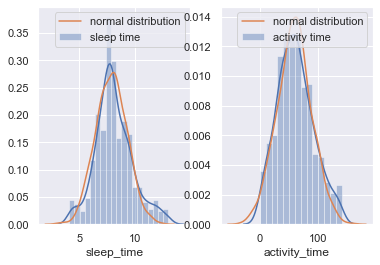

In [284]:
fig, ax =plt.subplots(1,2)
sns.distplot(sleep_act_cut.sleep_time, norm_hist = True, label = 'sleep time', ax=ax[0])
value = np.random.normal(loc=sleep_act_cut.sleep_time.median(),scale=1.4,size=1000)
sns.distplot(value, hist = False, label = 'normal distribution', ax=ax[0])

sns.distplot(sleep_act_cut.activity_time, norm_hist = True, label = 'activity time', ax=ax[1])
value = np.random.normal(loc=sleep_act_cut.activity_time.median(),scale=30,size=1000)
sns.distplot(value, hist = False, label = 'normal distribution', ax=ax[1])
fig.show()

It's hard to conclude about data normality based only on graphs

In [285]:
#test for normality

from scipy import stats
print('sleep_time: ', stats.shapiro(sleep_act_cut.sleep_time))
print('activity_time: ', stats.shapiro(sleep_act_cut.activity_time))

sleep_time:  ShapiroResult(statistic=0.9778175354003906, pvalue=3.338243175221578e-07)
activity_time:  ShapiroResult(statistic=0.9847992658615112, pvalue=2.457678237988148e-05)


Data distribution for both variables is not normal

In [286]:
from scipy.stats import mannwhitneyu
print('sleep_time: ',mannwhitneyu(sleep_act.sleep_time, sleep_act_cut.sleep_time))
print('activity_time: ', mannwhitneyu(sleep_act.activity_time, sleep_act_cut.activity_time))

sleep_time:  MannwhitneyuResult(statistic=185981.5, pvalue=0.22242147745569002)
activity_time:  MannwhitneyuResult(statistic=168266.5, pvalue=0.0001767665301753536)


The test show that sleep_time sample has no significant differences with the primary one. But for activity_time influence of outliers is more significant. Further conclusions regarding activity_time has a chance to show a different picture from the primary dataset

## Statistical analysis 

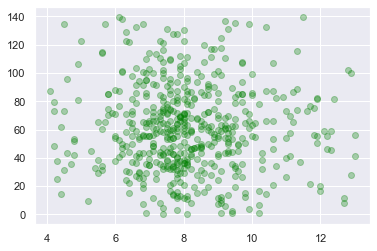

In [287]:
plt.scatter(sleep_act_cut['sleep_time'],sleep_act_cut['activity_time'], alpha = 0.3, color = "green")
plt.show()

From the graph we can see, that there no linkage between activity time and sleep time

In [288]:
coef, p = spearmanr(sleep_act_cut['activity_time'],sleep_act_cut['sleep_time'])
print('Spearmans correlation coefficient: %.3f' % coef)
# interpret the significance
alpha = 0.05
if p > alpha:
	print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
else:
	print('Samples are correlated (reject H0) p=%.3f' % p)

Spearmans correlation coefficient: -0.046
Samples are uncorrelated (fail to reject H0) p=0.286


Correlation coefficient is low so we can't conclude that the linkage between sleep_time and activity_time is significant

In [289]:
print(sleep_act_cut.mean())

sleep_time        8.114906
activity_time    60.859774
dtype: float64


## Analysis of full SamsungHeath data

In [290]:
# Read sqlite query results into a pandas DataFrame
con = sqlite3.connect('Amarin_db4.db')
shealth = pd.read_sql_query("SELECT steps.date, steps.steps, steps.speed, steps.distance, sleep.sleep_time, sleep.sleep_eff, body_metrics.heart_rate, body_metrics.calories, body_metrics.activity_time, users.gender, users.country, devices.OS FROM steps LEFT JOIN sleep ON steps.key=sleep.key LEFT JOIN body_metrics ON steps.key=body_metrics.key LEFT JOIN users ON steps.user=users.user LEFT JOIN devices ON steps.user=devices.user", con)
con.close()

shealth
#we can export it to excel if we want with this command - shealth.to_excel("output2.xlsx",sheet_name='Sheet_name_1')  

,date,steps,speed,distance,sleep_time,sleep_eff,heart_rate,calories,activity_time,gender,country,OS
0,2019-03-17,909,1.449,683.640,7.8,NaN,59.0,1838.49,58.96,male,BLR,Android
1,2019-03-18,4910,1.364,3735.090,8.2,NaN,57.0,2161.87,59.15,male,BLR,Android
2,2019-03-19,5813,1.365,4409.250,6.7,NaN,57.0,1977.46,54.52,male,BLR,Android
3,2019-03-20,5324,1.356,3995.100,NaN,NaN,60.0,2177.72,92.94,male,BLR,Android
4,2019-03-21,7341,1.301,5243.941,NaN,NaN,65.0,2192.80,74.19,male,BLR,Android
...,...,...,...,...,...,...,...,...,...,...,...,...
1049,2021-01-07,522,1.320,378.910,14.3,89.0,73.0,1490.67,28.97,female,POL,iOS
1050,2021-01-08,2749,1.247,1940.469,NaN,NaN,76.0,1442.31,5.22,female,POL,iOS
1051,2021-01-09,479,1.450,357.582,9.1,92.0,75.0,1447.88,8.11,female,POL,iOS
1052,2021-01-10,4177,1.420,3031.902,7.0,94.0,72.0,1530.79,35.07,female,POL,iOS


We can see, that there are a lot of NaNs in sleep data. The reason can be, that during the first time I take smartwatches of during sleeping. But then generally I slept with them.

In [291]:
shealth.describe()

,steps,speed,distance,sleep_time,sleep_eff,heart_rate,calories,activity_time
count,1054.000000,1054.000000,1054.000000,564.000000,425.000000,793.000000,793.00000,763.000000
mean,7329.480076,1.440362,5494.930668,8.057979,87.990588,71.332913,2024.14377,67.789961
std,5038.396825,0.102480,3889.607309,2.956293,8.734010,6.812061,542.88488,42.830212
min,7.000000,0.861000,5.680000,0.600000,25.000000,55.000000,1435.18000,0.000000
25%,4153.750000,1.380000,3092.771750,6.875000,87.000000,67.000000,1610.26000,41.140000
50%,6332.000000,1.432000,4625.543000,7.800000,91.000000,71.000000,2112.41000,60.030000
75%,9128.000000,1.482000,6890.419000,9.100000,92.000000,75.000000,2223.15000,86.075000
max,47620.000000,2.197000,38370.314000,23.600000,97.000000,111.000000,11094.47000,426.690000


There are outliers, but for the sake of correlation analysis we will leave it.

## NAN imputation

In [292]:
#Check NaNs
print(shealth.isna().sum())

date               0
steps              0
speed              0
distance           0
sleep_time       490
sleep_eff        629
heart_rate       261
calories         261
activity_time    291
gender             0
country            0
OS                 0
dtype: int64


The quality of our dataset is not perfect, because at the beginning users haven't wore smartwatch during the night as well as auto heart_rate measurement was off. For the clarity of correlation calculations we will drop all NaNs, but for the rest part of the projct we will use whole data.

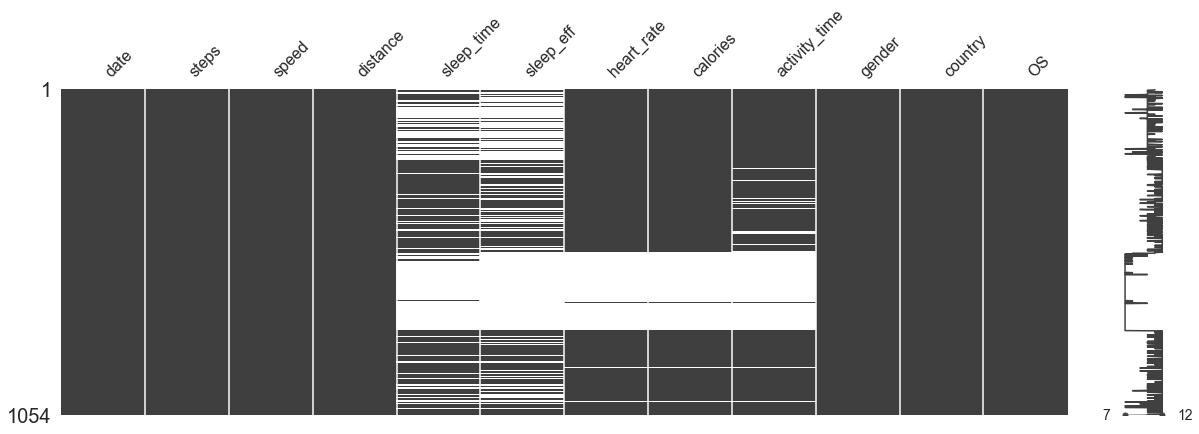

In [293]:
mno.matrix(shealth, figsize = (20, 6))

In [294]:
missing_data = ['sleep_time','sleep_eff','heart_rate', 'calories', 'activity_time']

In [295]:
for row in range(len(shealth['gender'])):
    if shealth.loc[row, 'gender'] == 'male':
        shealth.loc[row, 'gender'] = 1
    elif shealth.loc[row, 'gender'] == 'female': 
        shealth.loc[row, 'gender'] = 0

In [296]:
for row in range(len(shealth['OS'])):
    if shealth.loc[row, 'OS'] == 'Android':
        shealth.loc[row, 'OS'] = 1
    elif shealth.loc[row, 'OS'] == 'iOS': 
        shealth.loc[row, 'OS'] = 0

In [297]:
for row in range(len(shealth['country'])):
    if shealth.loc[row, 'country'] == 'BLR':
        shealth.loc[row, 'country'] = 1
    elif shealth.loc[row, 'country'] == 'POL': 
        shealth.loc[row, 'country'] = 0

I used machile learning technique to impute missing data based on existing values of the other features

In [298]:
imputer = IterativeImputer(BayesianRidge())
impute_data = pd.DataFrame(imputer.fit_transform(shealth.drop('date', axis = 1)), columns = shealth.columns[1:])

In [299]:
impute_data.describe()

,steps,speed,distance,sleep_time,sleep_eff,heart_rate,calories,activity_time,gender,country,OS
count,1054.000000,1054.000000,1054.000000,1054.000000,1054.000000,1054.000000,1054.000000,1054.000000,1054.000000,1054.000000,1054.000000
mean,7329.480076,1.440362,5494.930668,7.993593,87.693412,72.258353,1920.811943,65.612227,0.502846,0.502846,0.502846
std,5038.396825,0.102480,3889.607309,2.201930,6.112992,6.190655,507.347976,38.046400,0.500229,0.500229,0.500229
min,7.000000,0.861000,5.680000,0.600000,25.000000,55.000000,1435.180000,0.000000,0.000000,0.000000,0.000000
25%,4153.750000,1.380000,3092.771750,7.353770,85.000000,68.000000,1581.219172,44.862279,0.000000,0.000000,0.000000
50%,6332.000000,1.432000,4625.543000,7.980715,89.508913,73.390576,1870.000000,57.801222,1.000000,1.000000,1.000000
75%,9128.000000,1.482000,6890.419000,8.500000,90.757886,75.817478,2186.247500,79.150538,1.000000,1.000000,1.000000
max,47620.000000,2.197000,38370.314000,23.600000,97.000000,111.000000,11094.470000,426.690000,1.000000,1.000000,1.000000


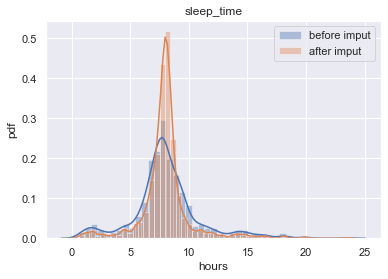

In [300]:
sns.set()
sns.distplot(shealth['sleep_time'], norm_hist = True)
sns.distplot(impute_data['sleep_time'], norm_hist = True)
plt.legend(['before imput','after imput'])
plt.title('sleep_time')
plt.xlabel('hours')
plt.ylabel('pdf')
plt.show()

In [345]:
shealth_NA = shealth.copy()
for feature in missing_data:
    shealth_NA.loc[:,feature] = impute_data[feature]

In [302]:
print(shealth_NA.isnull().any())

date             False
steps            False
speed            False
distance         False
sleep_time       False
sleep_eff        False
heart_rate       False
calories         False
activity_time    False
gender           False
country          False
OS               False
dtype: bool


## Hypothesis testing

In [350]:
#test for normality
from scipy import stats
stats.shapiro(shealth_NA.sleep_time)

ShapiroResult(statistic=0.8034204244613647, pvalue=6.646894795684531e-34)

We reject the hypothesis, that shealth.steps is normally distributed, so we're going to use non-parametric test for further hypothesis testing.

In [351]:
#test for equality of variances
from scipy.stats import mannwhitneyu
mannwhitneyu(shealth.sleep_time.dropna(), shealth_NA.sleep_time)

MannwhitneyuResult(statistic=291192.0, pvalue=0.2501612424402354)

In [352]:
#test for equality of central's location metric
from scipy.stats import median_test
median_test(shealth.sleep_time.dropna(), shealth_NA.sleep_time)

(3.7261664446149085,
 0.05356620158119908,
 7.937654669201359,
 array([[263, 546],
        [301, 508]], dtype=int64))

As steps are the most consistend variable we will test NA imputation effect on it. The dataset with dropped NaNs hasn't statistically different distribution and median from original dataset (p-value is grater than 0.05). So we can assume that shealth_NA is representative sample of the original dataset.

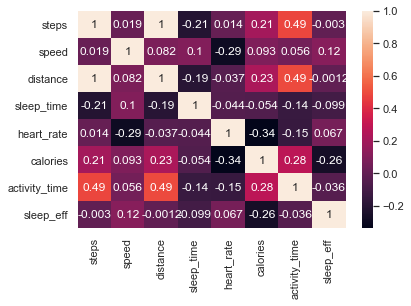

In [311]:
#Correlation matrix

corr_df = pd.DataFrame(shealth_NA,columns=['steps','speed','distance','sleep_time', 'heart_rate', 'calories', 'activity_time', 'sleep_eff'])
corrMatrix = corr_df.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

We can see clear correlation between steps and distance what is quite obvious. Steps are included in activity_time the correlation between these variables is quite high too. Generally the rest of variables doesn't show high correlation, but we can get the unusual results from correlation of heart rate and speed and calories, from which we can assume, that the higher speed - the lower heart rate and the less calories are burned. This situation can be the result of specific time of heart measuremet: the device measures rates every 10 minutes and if watches wasn't too close to hand - the measurement will fail. Continious measurement could give better results.

## Steps by gender

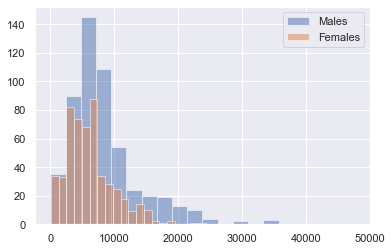

In [315]:
plt.hist(shealth_NA[shealth_NA['gender']==1]['steps'], bins=20, alpha=0.5, label='Males')
plt.hist(shealth_NA[shealth_NA['gender']==0]['steps'], bins = 20, alpha=0.5, label='Females')
plt.legend(loc='upper right')
plt.show()

On this graph we're comapring steps distribution of males and females. Both variables are close to normal distribution, but males tend to walk 37% more than women. 

In [316]:
x = shealth_NA.groupby(['gender'])
print('Males:')
display(x.get_group(1)['steps'].mean())
print('Females:')
display(x.get_group(0)['steps'].mean())

Males:


8489.452830188678

Females:


6156.225190839695

## Speed by country (timeline)

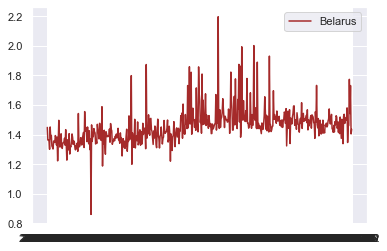

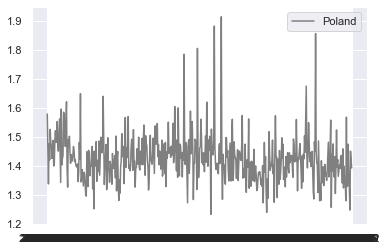

In [318]:
#plt.plot(shealth[shealth['gender']=='male']['calories'], label='Males')
plt.plot(shealth_NA[shealth_NA['country']==1]['date'], shealth_NA[shealth_NA['country']==1]['speed'], color = 'brown', label='Belarus')
plt.legend(loc='upper right')
plt.show()
plt.plot(shealth_NA[shealth_NA['country']==0]['date'], shealth_NA[shealth_NA['country']==0]['speed'],color = 'grey',label='Poland')
plt.legend(loc='upper right')
plt.show()

In [319]:
shealth.groupby(['country']).agg({'speed':[np.mean, np.std, 'max', 'min']})

speed                        
             mean       std    max    min
country                                  
0        1.424752  0.080455  1.913  1.232
1        1.455796  0.118429  2.197  0.861

Belarussian pedestrians have higher speed than women, but polish's speed is more stable and less variative.  

## Steps in seasons

In [320]:
#Dividing our dataset by date to warm and cold seasons
summer2019 = shealth[(shealth['date']>='2019-03-17') & (shealth['date']<='2019-09-30')][['date','steps']]
winter2019=shealth[(shealth['date']>'2019-09-30') & (shealth['date']<'2020-04-01')][['date','steps']]
summer2020=shealth[(shealth['date']>='2020-04-01') & (shealth['date']<='2020-09-30')][['date','steps']]
winter2020=shealth[(shealth['date']>='2020-10-01') & (shealth['date']<='2021-01-10')][['date','steps']]

[]

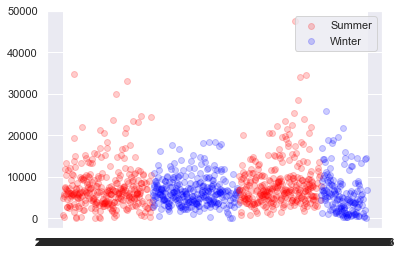

In [321]:
plt.scatter(summer2019['date'],summer2019['steps'], alpha = 0.20, color='red',label='Summer')
plt.scatter(winter2019['date'],winter2019['steps'], alpha = 0.20, color='blue',label='Winter')
plt.scatter(summer2020['date'],summer2020['steps'], alpha = 0.20, color='red')
plt.scatter(winter2020['date'],winter2020['steps'], alpha = 0.20, color='blue')
plt.legend()
plt.plot()

In [322]:
#Kruskal-Walis analysis

stats.kruskal(summer2019['steps'],winter2019['steps'],summer2020['steps'],winter2020['steps'])

KruskalResult(statistic=35.11129031424779, pvalue=1.1540456248419e-07)

From this graph we see that during the warm seasons users tend to have more active walks comparing to cold seasons. As during hypothesis testing we have found that steps data isn't normally distributed, we can't use ANOVA to compare variances. So, accordind to Krusall-Walis non-parametric test we are able to reject null-hypothesis, that our season's medians are equal. 

In [323]:
#Creating labeled datased for post-hoc analysis

summer2019['season']='summer2019'
winter2019['season']='winter2019'
summer2020['season']='summer2020'
winter2020['season']='winter2020'
seasons=pd.concat([summer2019, summer2020,winter2019,winter2020])

In [324]:
import scikit_posthocs as sp
sp.posthoc_conover(seasons, val_col='steps', group_col='season', p_adjust = 'holm')

,summer2019,summer2020,winter2019,winter2020
summer2019,1.000000,1.628210e-02,0.316248,1.594060e-03
summer2020,0.016282,1.000000e+00,0.000964,4.287369e-08
winter2019,0.316248,9.639374e-04,1.000000,1.628210e-02
winter2020,0.001594,4.287369e-08,0.016282,1.000000e+00


According to host-hoc analysis we can assume that there is no significant difference between steps in seasons during 2019, but all the rest seasons are significantly differ from each other.

## Heart rates by OS


[]

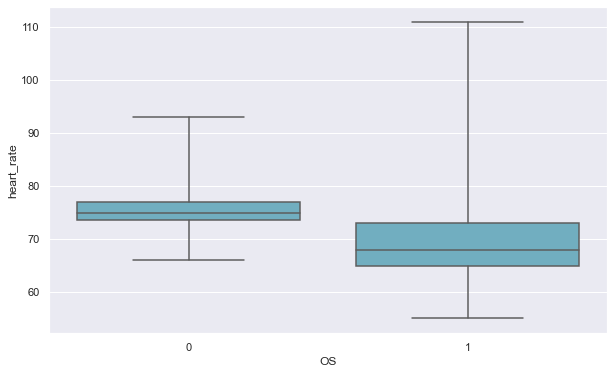

In [325]:
plt.figure(figsize=(10.0, 6))
# Plot the orbital period with horizontal boxes
sn.boxplot(x="OS", y="heart_rate", data=shealth_NA,
                 whis=np.inf, color="c")
plt.plot()

In [328]:
x = shealth_NA.groupby(['OS'])
print("Android's HR =", x.get_group(1)['heart_rate'].mean())
print("Android's std =",x.get_group(1)['heart_rate'].std())
print("iOS HR =",x.get_group(0)['heart_rate'].mean())
print("iOS HR std =",x.get_group(0)['heart_rate'].std())

Android's HR = 69.19281539675721
Android's std = 6.690579695373741
iOS HR = 75.35899121743603
iOS HR std = 3.567677631001022


Heart rates of Android users are lower than iOS rates, but the deviation is much higher. So, probably iOS users suffers less stress, than Android users, or Android users may have high phisical activities.

## Calories by gender

[]

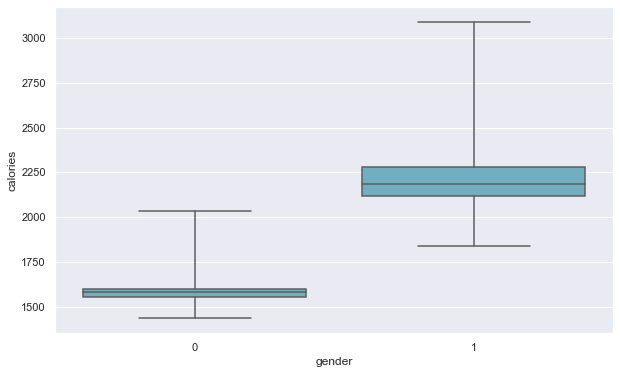

In [330]:
plt.figure(figsize=(10.0, 6))
sn.boxplot(x="gender", y="calories", data=shealth_NA[shealth_NA['calories']<4000],
                 whis=np.inf, color="c")
plt.plot()

In [331]:
shealth.groupby(['gender']).agg({'calories':[np.mean, 'max', 'min', np.std]})

calories                               
               mean       max      min         std
gender                                            
0       1580.874760   2035.81  1435.18   98.484504
1       2254.270019  11094.47  1838.49  536.410202

Men tend to use more calories, than women, so the difference seems quite normal. 

## Sleep time and sleep quality

[]

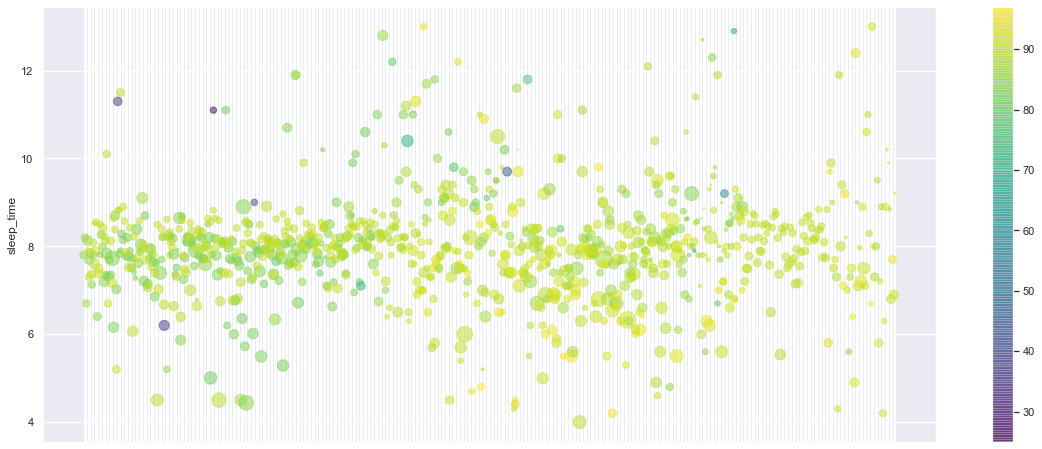

In [332]:
shealth_cut = shealth_NA.loc[(shealth_NA['sleep_time']<=13)&(shealth_NA['sleep_time']>=4),]
import matplotlib.cm as cmaps
shealth_cut.plot("date", "sleep_time", kind="scatter", figsize=(20,8), s=shealth_cut["activity_time"], alpha=0.5, c=shealth_cut["sleep_eff"], cmap=cmaps.viridis)
plt.plot()

This graph has a following characteristics:
* the bigger the mark - the higher activity time
* the brighter the mark - the higher sleep quality

From this graph we don't see clear linkage between sleep time and sleep quality. There are some slepp time values higher, than 10 hours level with lower quality level, but at the same time on this level we have values with high sleep quality. Generally seems that the better sleep quality is around the mean.

During the timeline sleep varies on wide range but the median value is around 8 hours. This value is independent from activity level. 

In [333]:
shealth_NA.sleep_time.mean()

7.9935927507803335

## KMeans clustering on my activity time since 01-07-2020

In [334]:
#Preparing data frame
shealth_km = shealth_NA.query('date >= "2020-07-01"')[['date','activity_time']]
shealth_km = shealth_km.dropna()
shealth_km['date']=list(range(0,len(shealth_km)))
shealth_km

,date,activity_time
381,0,94.730000
382,1,85.480000
383,2,84.100000
384,3,15.980000
385,4,47.410000
...,...,...
1049,300,28.970000
1050,301,5.220000
1051,302,8.110000
1052,303,35.070000


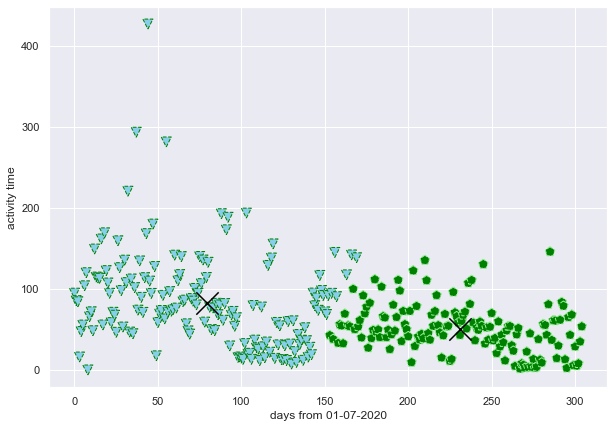

In [335]:
#Clustering

%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
ToCluster = shealth_km
kmeans = KMeans(n_clusters=2, random_state=42).fit(ToCluster)
labels = kmeans.labels_
new_df = pd.DataFrame(data = ToCluster, columns = ['date','activity_time'])
new_df['label_kmeans'] = labels
fig, ax = plt.subplots(figsize=(10,7))
plt.scatter(new_df["date"][new_df["label_kmeans"] == 0], new_df["activity_time"][new_df["label_kmeans"] == 0], 
            color = "skyblue", s=100, edgecolor='green',linestyle='--', marker="v")
plt.scatter(new_df["date"][new_df["label_kmeans"] == 1], new_df["activity_time"][new_df["label_kmeans"] == 1], 
            color = "green", s=100, edgecolor='lightgreen',linestyle='--', marker="p")
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=500, marker="x");
ax.set_xlabel('days from 01-07-2020')
ax.set_ylabel('activity time')
plt.show()

In [336]:
from sklearn.metrics import silhouette_score
kmeans_silhouette = silhouette_score(ToCluster, kmeans.labels_).round(2)
kmeans_silhouette

0.5

Silhouette score measures clustering quality and varies from -1 to 1. Reached value indicates that our clustering quality can be assumed as acceptable, but not perfect.

In [337]:
new_df.groupby(['label_kmeans']).agg({'activity_time':[np.mean, np.std, 'max', 'min']})

activity_time                        
                      mean        std     max  min
label_kmeans                                      
0                83.123292  58.468246  426.69  0.0
1                50.741115  29.412218  145.89  1.6

Clustering results clearly shows, that my activity fall dramaticaly since November. I moved to Warsaw on 26th of October and my habbits have changed signifacantly: now paying much attention to study. Also Poland has more strict pandemic restrictions, so I'm trying to stay home. So, clustering results are acceptable. 

But definately I should stay active, doing some physical exersises at home or making any other activity to stay healthy. Nowadays it is very important! 
One can find the list of 20-minuthes everyday home phisycal excersises here - https://www.healthline.com/health/fitness-exercise/at-home-workouts. 

Thanks for attention!

Stay healthy

## Classes (extra)

In [338]:
class Plots:
    def steps_hist(self):  #male or female
        plt.hist(shealth[shealth['gender']==self]['steps']) 
        
    def speed_graph(self): #BLR or POL
        plt.plot(shealth[shealth['country']==self]['date'], shealth[shealth['country']==self]['speed'],color = 'grey',label=self)
        plt.legend(loc='upper right')
        plt.show()
        
    def seasons_steps(self): #summer2019, winter2019, summer2020, winter2020
        plt.scatter(self['date'],self['steps'], alpha = 0.20, color="red",label=self)
        
    def boxplots(self1, self2): #any
        sn.boxplot(x=self1, y=self2, data=shealth, whis=np.inf, color="c")
        
    def sleep_chart(size, color): #any
        shealth.plot("date", "sleep_time", kind="scatter", figsize=(20,8), s=shealth[size], alpha=0.7, c=shealth[color], cmap=cmaps.viridis)

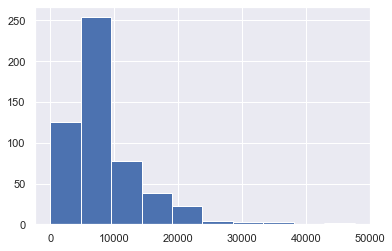

In [340]:
Plots.steps_hist(1)

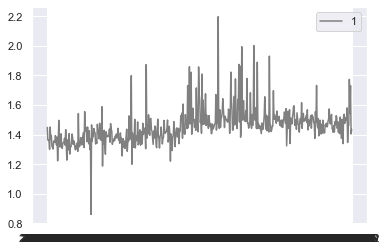

In [341]:
Plots.speed_graph(1)

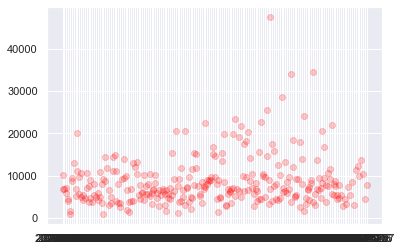

In [342]:
Plots.seasons_steps(summer2020)

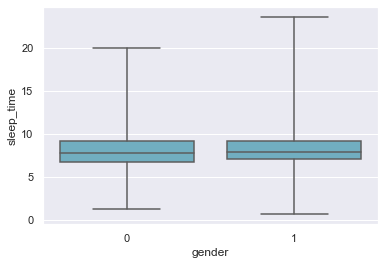

In [343]:
Plots.boxplots('gender',"sleep_time")

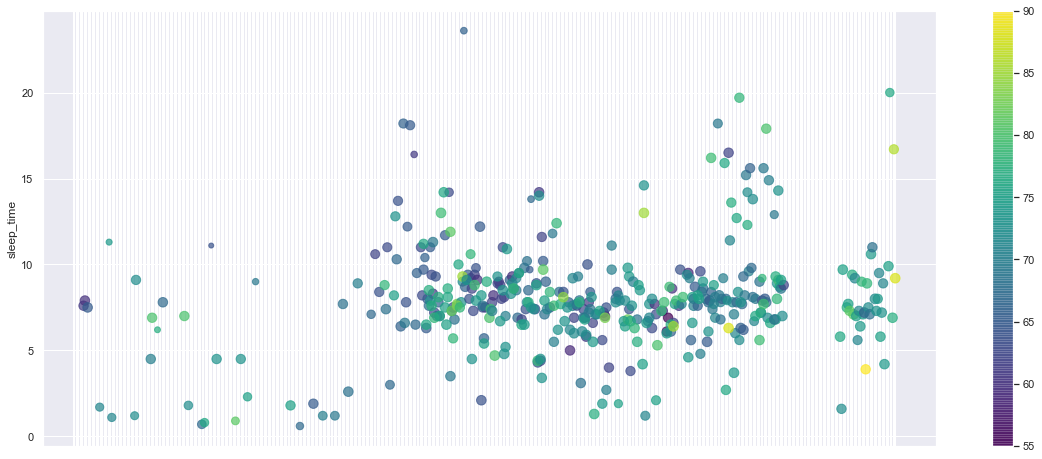

In [344]:
Plots.sleep_chart("sleep_eff", "heart_rate")